# Gridshift Hackathon

In [640]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import Point, LineString
import glob
import json
import osmapi as osm
import geoplot
from shapely.ops import nearest_points

In [2]:
dmv = pd.read_excel("data/PCE - DMV Data - January 2020.xlsx") 

In [48]:
usa = gpd.read_file('data/us_states.geojson')

# Datasets

## Zipcode Dataset


Shapefile of zipcode areas in California.

In [252]:
zipcode = gpd.read_file("data/ca_california_zip_codes_geo.min.json")

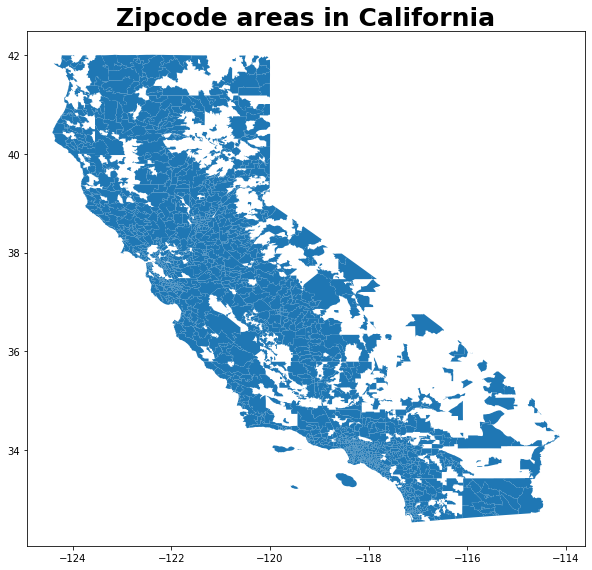

In [762]:
fig, ax = plt.subplots(figsize=(10, 10))
zipcode.plot(ax=ax)
plt.title("Zipcode areas in California", fontsize=25, fontweight="bold")
plt.show()

In [253]:
zipcode["ZCTA5CE10"] = zipcode.ZCTA5CE10.apply(lambda x: str(int(float(x))))
#.astype({"ZCTA5CE10": "int32"})

In [257]:
len(dmv.merge(zipcode, right_on="ZCTA5CE10", left_on="ZIP"))

732533

## DMV dataset

PCE - DMV dataset

In [23]:
len(dmv)

1048575

In [30]:
dmv = dmv[~dmv[["ZIP", "Fuel", "Ownership"]].isna().any(axis=1)]

In [256]:
dmv["ZIP"] = dmv.ZIP.apply(lambda x: str(int(float(x))))

<ipython-input-256-291bcfe3d478>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dmv["ZIP"] = dmv.ZIP.apply(lambda x: str(int(float(x))))


In [766]:
dmv_zips = dmv.ZIP.unique()
zip_code_zips = zipcode.ZCTA5CE10.unique()

No handles with labels found to put in legend.


[]

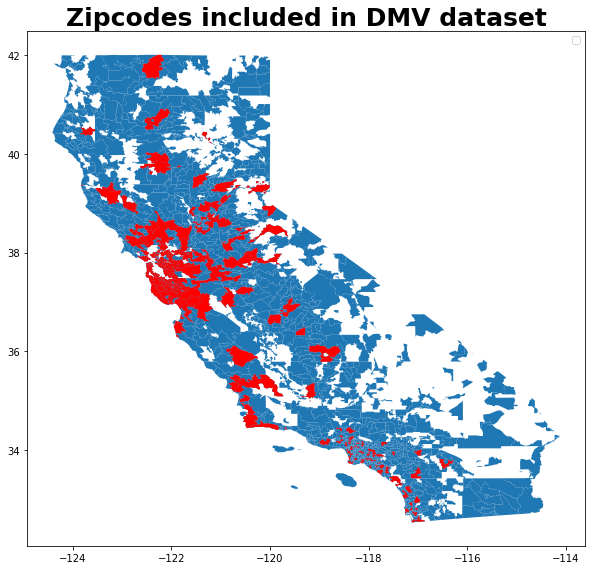

In [768]:
fig, ax = plt.subplots(figsize=(10, 10))
zipcode.plot(ax=ax)
zipcode[zipcode.ZCTA5CE10.isin(dmv_zips)].plot(ax=ax, color="red")
plt.legend()
plt.title("Zipcodes included in DMV dataset", fontsize=25, fontweight="bold")
#usa[usa.name == "California"].plot(ax=ax, color='white', edgecolor='black')
plt.plot()

## Charging Stations

In [108]:
URL = "https://developer.nrel.gov/api/alt-fuel-stations/v1.json"

In [117]:
PARAMS = {"api_key": "x7RHPxStAmIL7a8Q6NOMdneNdK0bPqZiXwZGXj0P",
           "fuel_type": "ELEC",
         "state": "CA"}

In [118]:
r = requests.get(url = URL, params=PARAMS)

In [119]:
loc_charge = r.json()

In [120]:
len(loc_charge['fuel_stations'])

6789

In [155]:
chargers = pd.DataFrame.from_dict(loc_charge['fuel_stations'])

In [156]:
chargers_cols = ['access_code', 'access_days_time', 'fuel_type_code', 'groups_with_access_code', 'id',
       'owner_type_code', 'facility_type', 'latitude', 'longitude', 'city', 'zip',
        'ev_connector_types',  'ev_network']

In [157]:
chargers = chargers[(chargers.status_code == "E")][~(chargers.latitude > 80)][chargers_cols]

<ipython-input-157-e9d948222776>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chargers = chargers[(chargers.status_code == "E")][~(chargers.latitude > 80)][chargers_cols]


In [158]:
chargers["geometry"] = chargers.apply(lambda x: Point(x["longitude"], x["latitude"]), axis=1)

In [159]:
chargers = gpd.GeoDataFrame(chargers, geometry='geometry')

/home/abanquet/anaconda3/envs/fem/lib/python3.8/site-packages/geopandas/plotting.py:507: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


[]

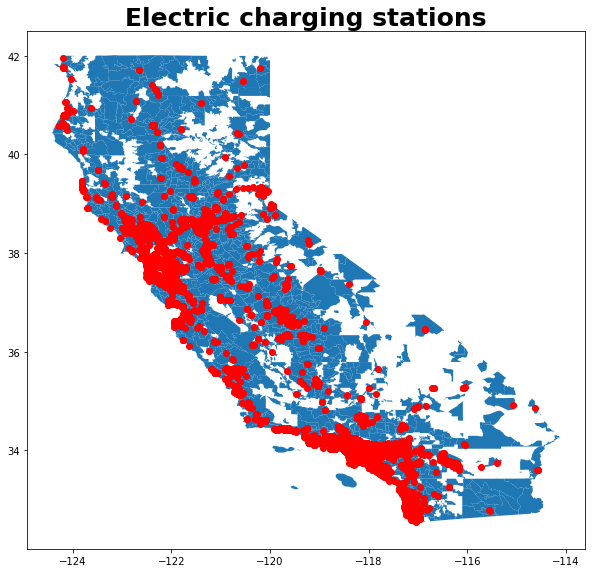

In [769]:
fig, ax = plt.subplots(figsize=(10, 10))
zipcode.plot(ax=ax)
zipcode[zipcode.ZCTA5CE10.isin(dmv_CG_E_zips)].plot(ax=ax, color="green")
chargers.plot(ax=ax, color="red")
plt.title("Electric charging stations", fontsize=25, fontweight="bold")
#usa[usa.name == "California"].plot(ax=ax, color='white', edgecolor='black')
plt.plot()

## PCE customers dataset

We consider the zipcodes located within PCE juridiction.

In [540]:
pce_zips = pd.read_excel('data/Zipcodes + Types cutomer EVSE.xlsx')

In [541]:
pce_zips["ZIP"] = pce_zips["ZIP"].apply(lambda x: x.split(" ")[2])

In [575]:
pce_zipcode = zipcode.merge(pce_zips, left_on = "ZCTA5CE10", right_on="ZIP")

[]

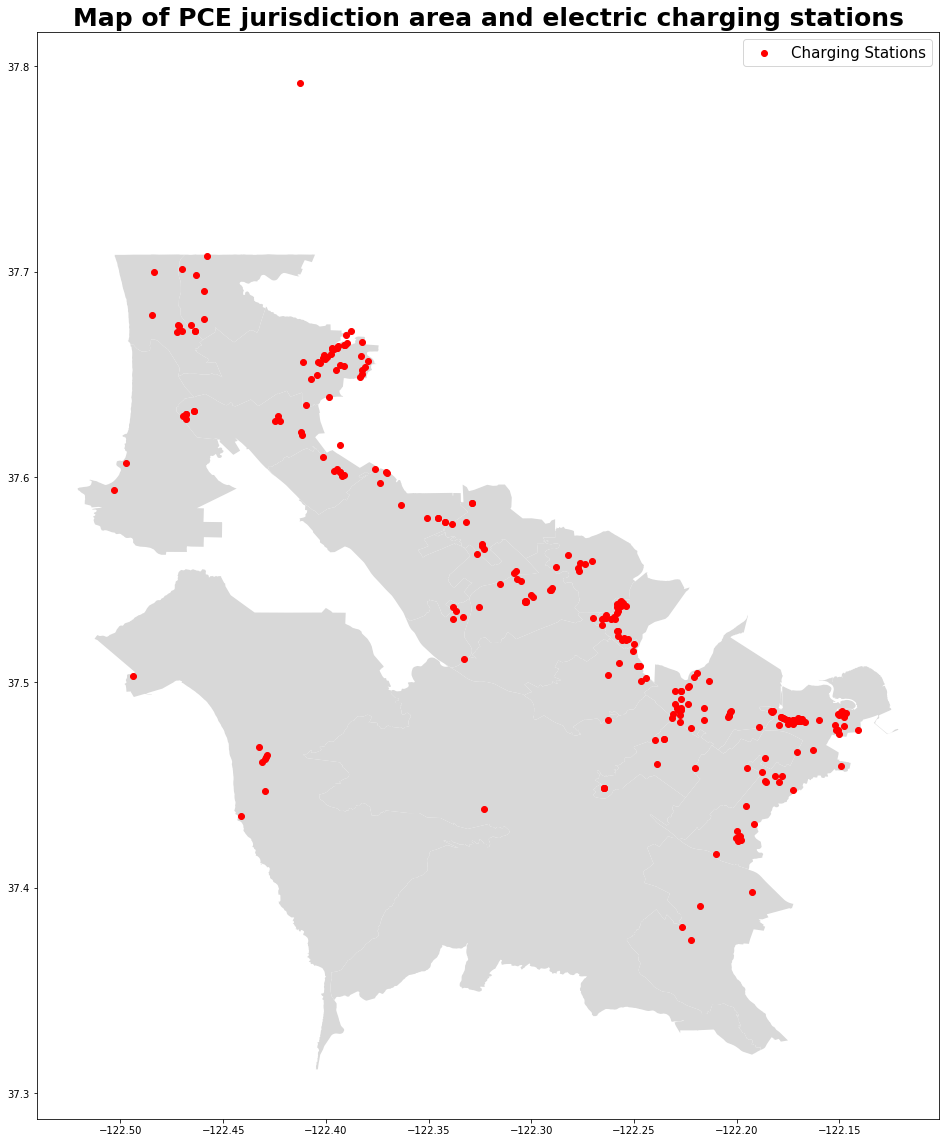

In [771]:
fig, ax = plt.subplots(figsize=(20, 20))
#zipcode.plot(ax=ax)
zipcode[zipcode.ZCTA5CE10.isin(pce_zips.ZIP)].plot(ax=ax, color="#D8D8D8")
chargers[chargers.zip.isin(pce_zips.ZIP)].plot(ax=ax, color="red", label="Charging Stations")
#usa[usa.name == "California"].plot(ax=ax, color='white', edgecolor='black')
plt.title("Map of PCE jurisdiction area and electric charging stations", fontsize=25, fontweight="bold")

plt.legend(fontsize=15)
plt.plot()


We build a fake customer dataset based on DMV dataset for PCE. PCE has 200000 customers. We then generate a random location for each customer within each zipcode.

In [517]:
pce = dmv[dmv.ZIP.isin(pce_zips.ZIP)].sample(n=200000)

In [518]:
pce = pce.merge(zipcode[["ZCTA5CE10", "geometry"]], left_on="ZIP", right_on="ZCTA5CE10").rename(columns={ "geometry": "ZIP_geometry"})

In [519]:
import random
from shapely.geometry import Point

def generate_random(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    while not polygon.contains(pnt):
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return pnt

In [520]:
pce["coordinate"] = pce.ZIP_geometry.apply(lambda x: generate_random(x))

In [521]:
pce = gpd.GeoDataFrame(pce, geometry="coordinate")

In [522]:
pce["Customer_ID"] = np.arange(len(pce))
pce["email"] = pce["Customer_ID"].apply(lambda x: "anonymous{}@customer.com".format(x))

In [523]:
pce = pce.set_index("Customer_ID")

[]

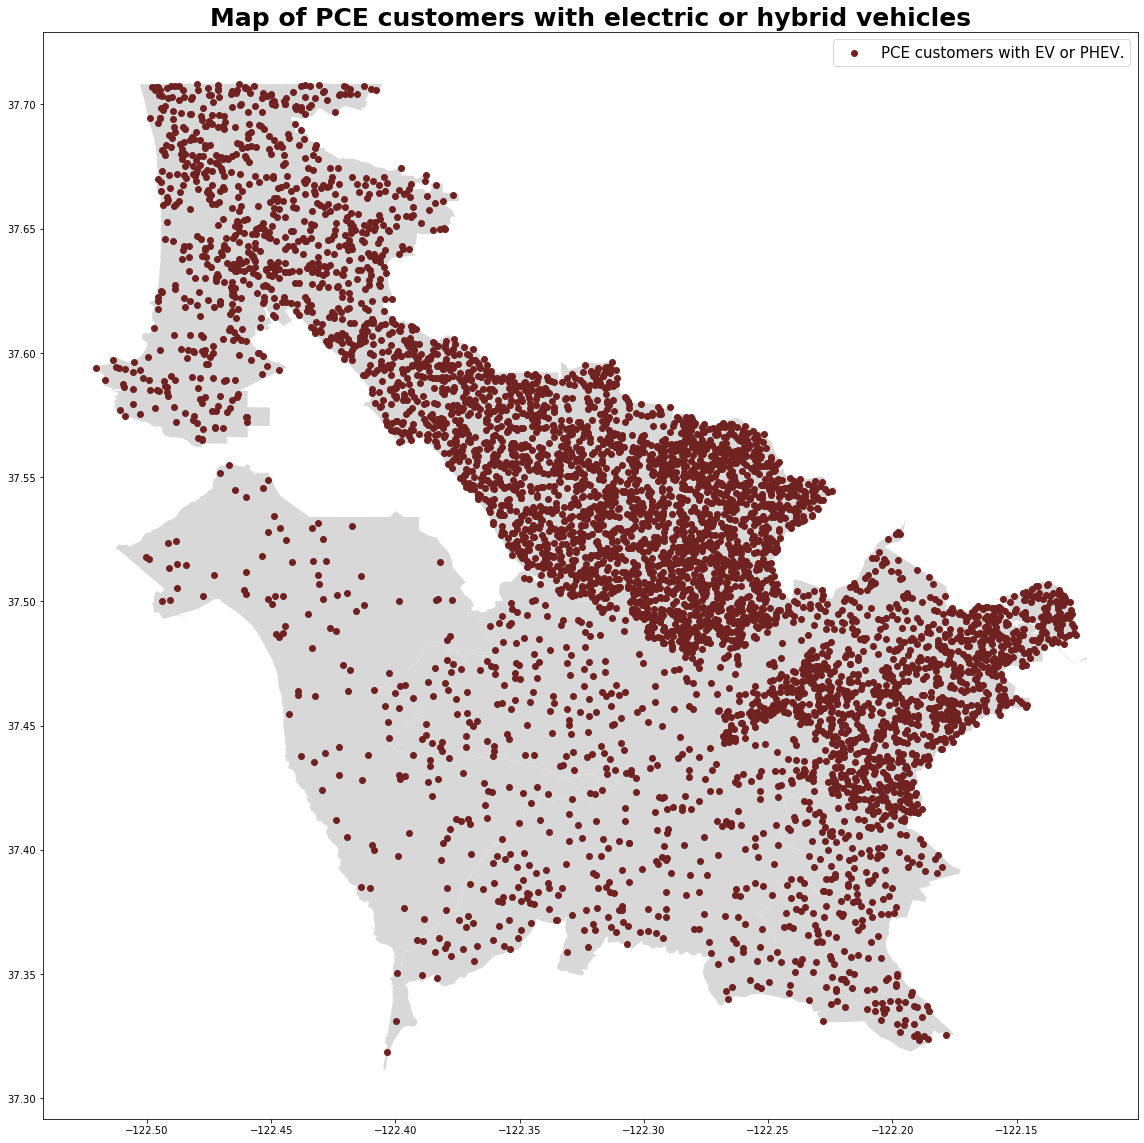

In [755]:
fig, ax = plt.subplots(figsize=(20, 20))
#zipcode.plot(ax=ax)
zipcode[zipcode.ZCTA5CE10.isin(pce_zips.ZIP)].plot(ax=ax, color="#D8D8D8")
#chargers[chargers.zip.isin(pce_zips.ZIP)].plot(ax=ax, color="red", label="Charging Stations")
pce[pce.Fuel.isin(["E", "PHEV"])].plot(ax=ax, color="#702221", label="PCE customers with EV or PHEV.")
#usa[usa.name == "California"].plot(ax=ax, color='white', edgecolor='black')
plt.title("Map of PCE customers with electric or hybrid vehicles", fontsize=25, fontweight="bold")

plt.legend(fontsize=15)
plt.plot()


### Poverty and income data

In [611]:
income = pd.read_csv("data/Vital_Signs__Unemployment_Rate___by_city.csv")
income = income[income.Year == 2015].drop(columns=["Year"])
income = income.merge(pce_zipcode, on="City")
income = gpd.GeoDataFrame(income)

In [627]:
poverty = pd.read_csv("data/Vital_Signs__Poverty_-_by_city.csv")
poverty = poverty[poverty.Year == 2017].drop(columns=["Source", "Year"])
poverty = poverty.merge(pce_zipcode, on="City")
poverty = gpd.GeoDataFrame(poverty)

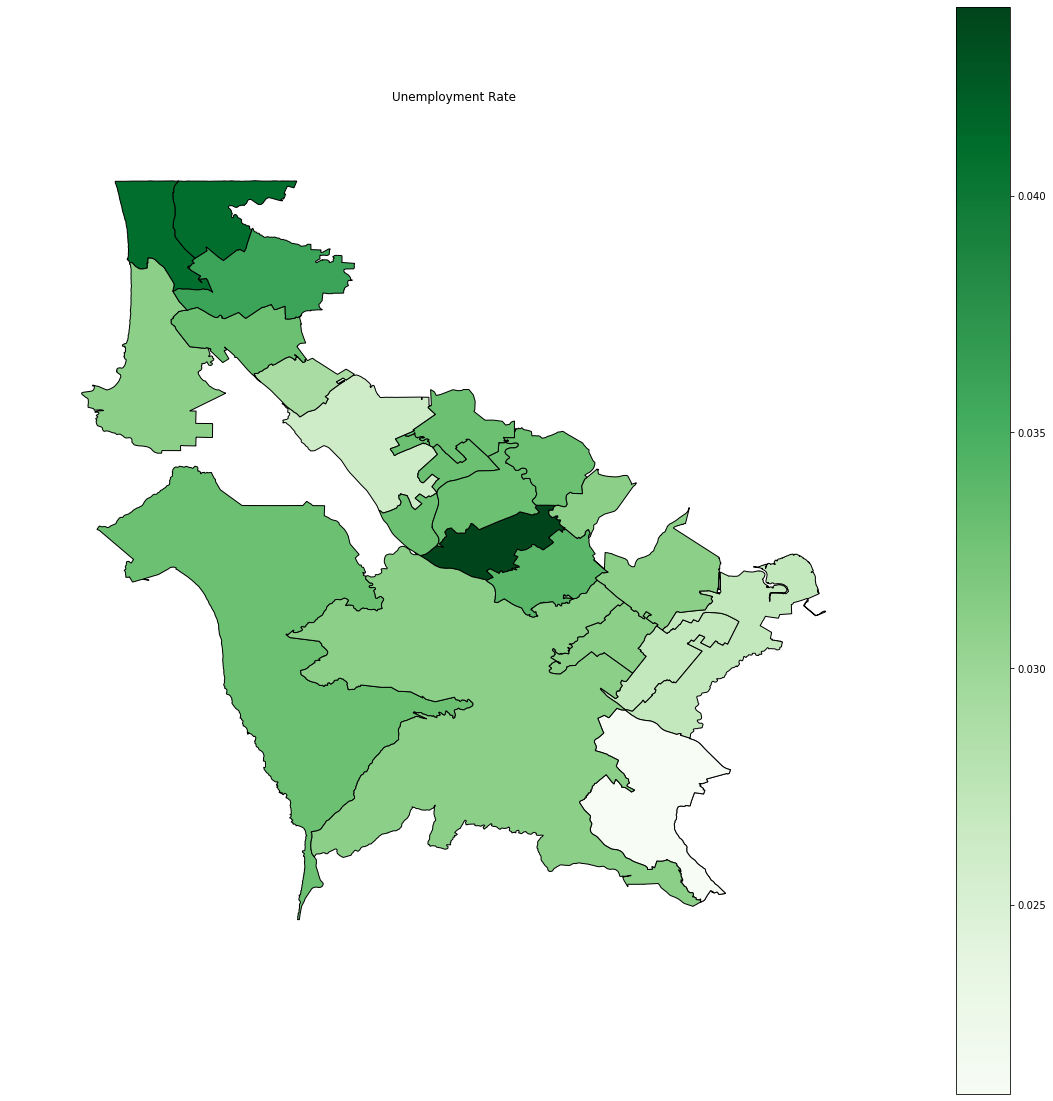

In [595]:
fig, ax = plt.subplots(figsize=(20, 20))
geoplot.choropleth(
    income, hue=income['Unemployment_Rate'],
    cmap='Greens', figsize=(8, 4), ax=ax, legend=True
)
plt.title("Unemployment Rate")
plt.show()

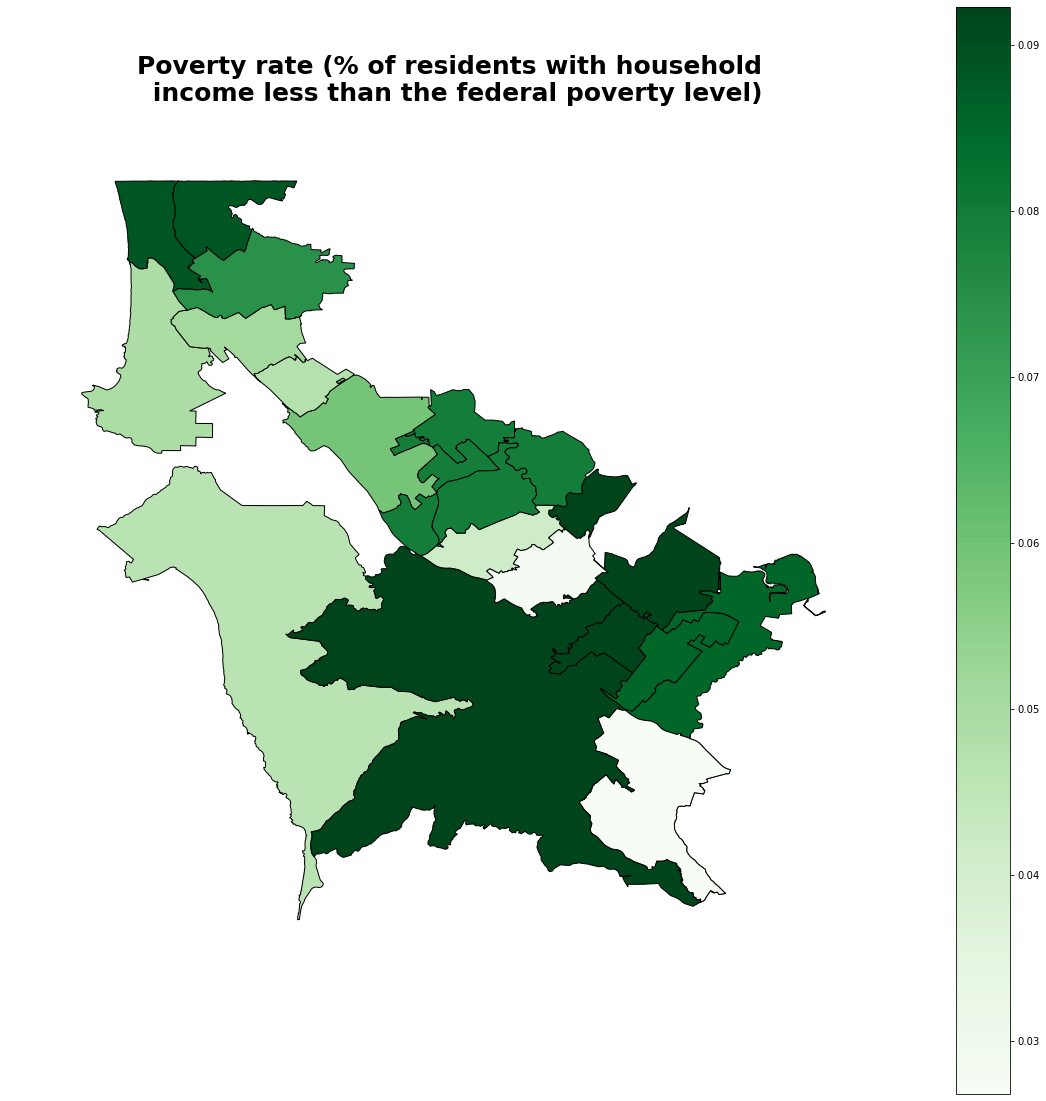

In [754]:
fig, ax = plt.subplots(figsize=(20, 20))
geoplot.choropleth(
    income, hue=poverty['PovPCT100'],
    cmap='Greens', figsize=(8, 4), ax=ax, legend=True
)
plt.title("Poverty rate (% of residents with household \n income less than the federal poverty level)", fontsize=25, fontweight="bold")
plt.show()

# Our approach to expand Electric Vehicles

### 1. Target C&I and G customers with EVs

In [440]:
pce_target_cg = pce[(pce.Fuel.isin(["E", "PHEV"]))&(pce.Ownership.isin(["G", "C"]))]

[]

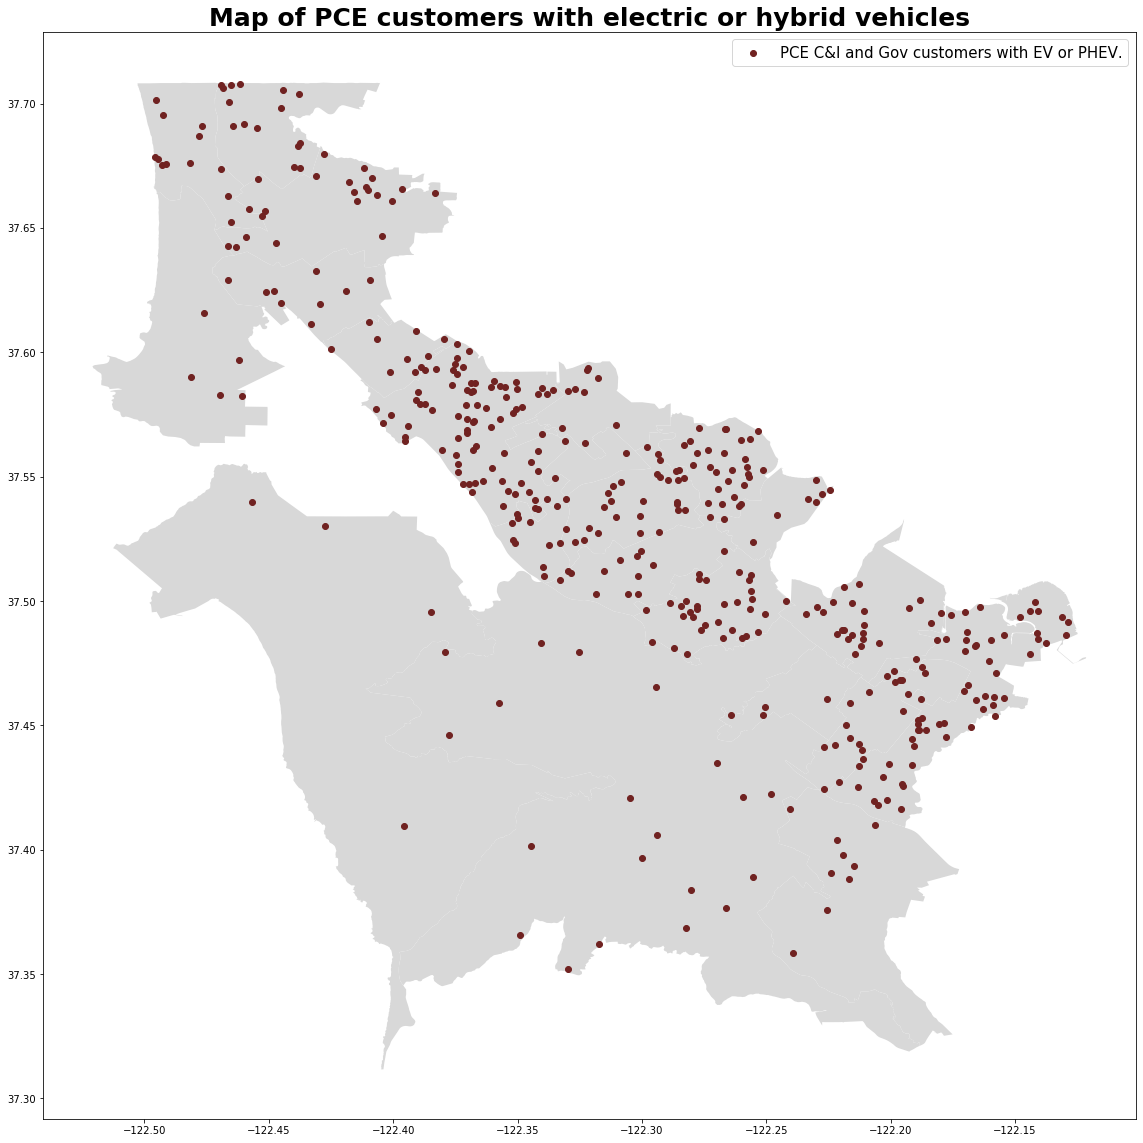

In [751]:
fig, ax = plt.subplots(figsize=(20, 20))
#zipcode.plot(ax=ax)
zipcode[zipcode.ZCTA5CE10.isin(pce_zips.ZIP)].plot(ax=ax, color="#D8D8D8")
#chargers[chargers.zip.isin(pce_zips.ZIP)].plot(ax=ax, color="red", label="Charging Stations")
pce_target_cg.plot(ax=ax, color="#702221", label="PCE C&I and Gov customers with EV or PHEV.")
#usa[usa.name == "California"].plot(ax=ax, color='white', edgecolor='black')
plt.title("Map of PCE customers with electric or hybrid vehicles", fontsize=25, fontweight="bold")

plt.legend(fontsize=15)
plt.plot()

### 2. Send an email to the targeted C&I and Gov customers

### 3. Collect their answers

Let's consider that 30% of the C&I and Gov customers replied they are ready to rent their charging station at night.

In [437]:
answers = np.random.binomial(1, 0.3, size=len(pce_target))

In [442]:
pce_target_cg["answer"] = answers

<ipython-input-442-cde4a3333fd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pce_target_cg["answer"] = answers


In [632]:
pce_target_cg1 = pce_target_cg[pce_target_cg.answer == 1]

### 4. Target Residential customers close to target C&I and Govmt customers ready to rent their charging stations.

In [678]:
pce_target_res = pce[(pce.Ownership == "P")&(pce.Fuel.isin(["D", "F", "G", "HD", "HG", "HD", "N", "O", "P"]))]

In [680]:
#Determine closest C&I and Gvmt customer charger's distance
pce_target_res["closest"] = pce_target_res.coordinate.apply(lambda x: nearest_points(x, pce_target_cg1.coordinate.unary_union)[1])

<ipython-input-680-db4b48e68dca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pce_target_res["closest"] = pce_target_res.coordinate.apply(lambda x: nearest_points(x, pce_target_cg1.coordinate.unary_union)[1])


In [681]:
pce_target_res["closest_distance"] = pce_target_res.apply(lambda x: x["coordinate"].distance(x["closest"]), axis=1)

<ipython-input-681-da11f477b2b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pce_target_res["closest_distance"] = pce_target_res.apply(lambda x: x["coordinate"].distance(x["closest"]), axis=1)


In [ ]:
#Determine closest public charger's distance
#pce_target_res["closest_public"] = pce_target_res.coordinate.apply(lambda x: nearest_points(x, chargers[chargers.access_code == "public"].geometry.unary_union)[1])
#pce_target_res["closest_public_distance"] = pce_target_res.apply(lambda x: x["coordinate"].distance(x["closest_public"]), axis=1)

#Too computationally intensive

In [694]:
pce_target_res = pce_target_res.merge(income[["ZIP", "Unemployment_Rate"]][~income.ZIP.duplicated()], on="ZIP")

In [696]:
pce_target_res = pce_target_res.merge(poverty[["ZIP", "PovPCT100"]][~poverty.ZIP.duplicated()], on="ZIP")

Determine target potential

In [731]:
weigths = {"PovPCT100": 0.2,
           "Unemployment_Rate": 0,
           "closest_distance": 0.8}

In [732]:
pce_target_res["target_potential"] = np.zeros(len(pce_target_res))
pce_target_res["target_potential"] += weigths["closest_distance"] *(1 - (pce_target_res["closest_distance"] - pce_target_res["closest_distance"].min()) / (pce_target_res["closest_distance"].max() - pce_target_res["closest_distance"].min()))
    
for feature in ["Unemployment_Rate", "PovPCT100"]:
    pce_target_res["target_potential"] += weigths[feature] * (pce_target_res[feature] - pce_target_res[feature].min()) / (pce_target_res[feature].max() - pce_target_res[feature].min())
pce_target_res = pce_target_res.sort_values("target_potential", ascending=False)

[]

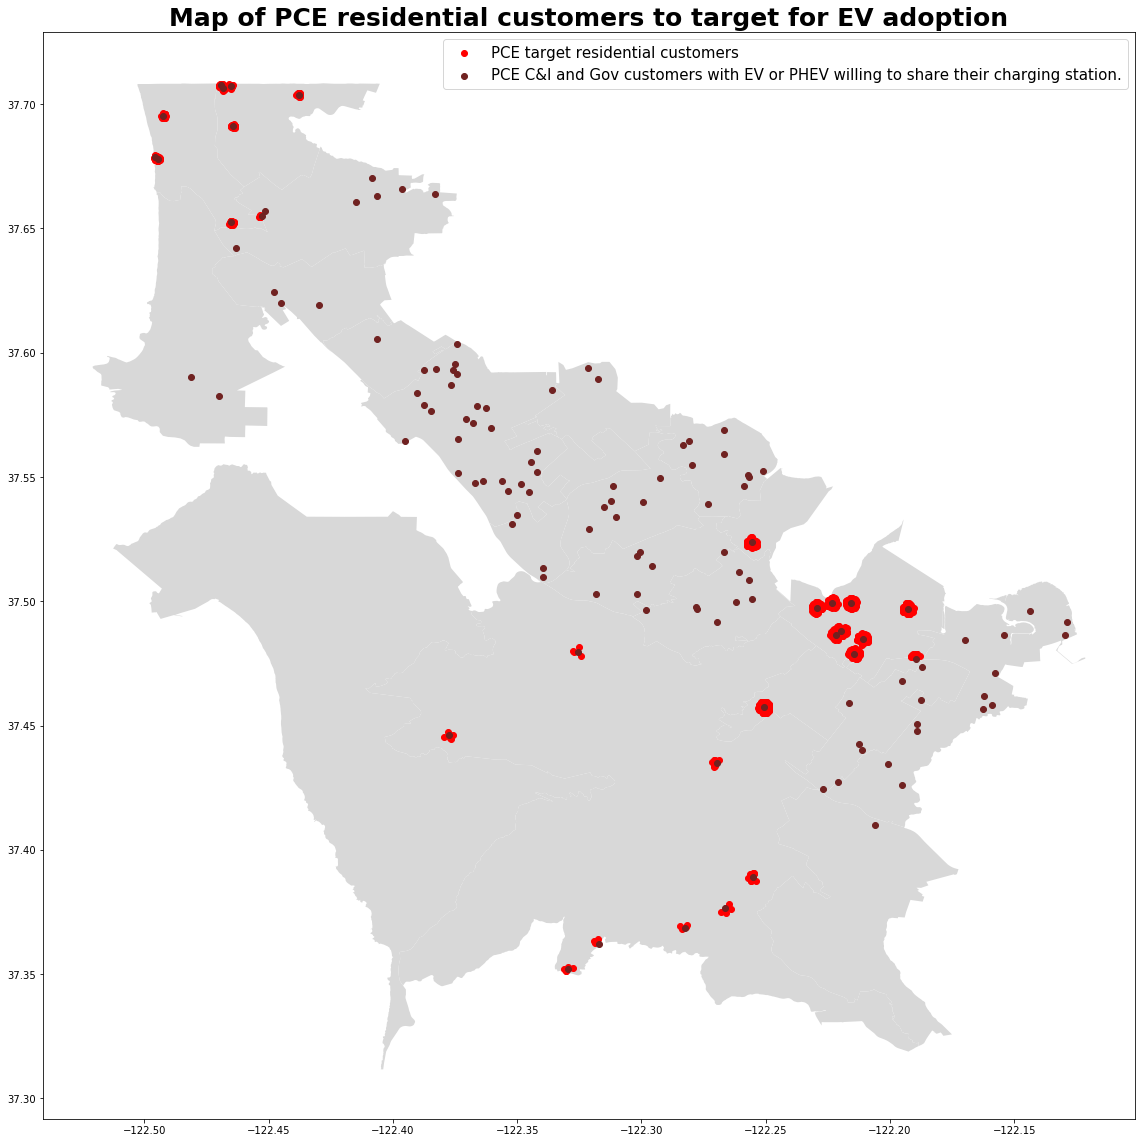

In [745]:
fig, ax = plt.subplots(figsize=(20, 20))
#zipcode.plot(ax=ax)
zipcode[zipcode.ZCTA5CE10.isin(pce_zips.ZIP)].plot(ax=ax, color="#D8D8D8")
pce_target_res[:1000].plot(ax=ax, color="red", label="PCE target residential customers")
pce_target_cg[pce_target_cg.answer ==1].plot(ax=ax, color="#702221", label="PCE C&I and Gov customers with EV or PHEV willing to share their charging station.")
plt.title("Map of PCE residential customers to target for EV adoption", fontsize=25, fontweight="bold")
plt.legend(fontsize=15)
plt.plot()

/home/abanquet/anaconda3/envs/fem/lib/python3.8/site-packages/geopandas/geodataframe.py:557: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/home/abanquet/anaconda3/envs/fem/lib/python3.8/site-packages/geopandas/geodataframe.py:557: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


[]

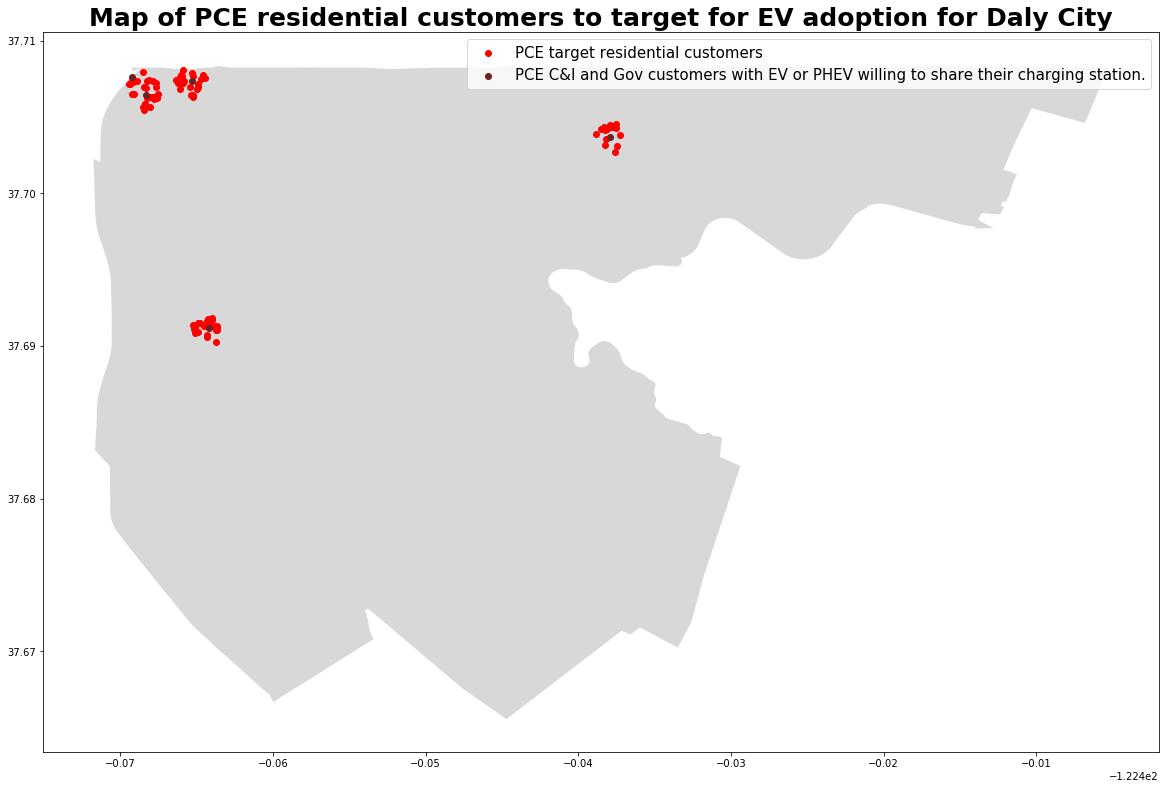

In [748]:
fig, ax = plt.subplots(figsize=(20, 20))
#zipcode.plot(ax=ax)
zipcode[zipcode.ZCTA5CE10 == "94014"].plot(ax=ax, color="#D8D8D8")
pce_target_res[:1000][pce_target_res.ZIP == "94014"].plot(ax=ax, color="red", label="PCE target residential customers")
pce_target_cg[pce_target_cg.answer ==1][pce_target_cg.ZIP == "94014"].plot(ax=ax, color="#702221", label="PCE C&I and Gov customers with EV or PHEV willing to share their charging station.")
plt.title("Map of PCE residential customers to target for EV adoption for Daly City", fontsize=25, fontweight="bold")
plt.legend(fontsize=15)
plt.plot()